## Exploring and Harvesting Play-By-Play Boxscores
Sean Steinle

1. [Introduction](#1)
2. [Loading, Exploring Data](#2)
3. [Harvesting Kickoff Stats with RE](#3)

<a id="1">

### Introduction


<a id="2">

### Loading, Exploring Data

In [1]:
#imports
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

In [2]:
#setting paths
PBP_data = "../nflscrapR-data/play_by_play_data/regular_season"
game_data = "../nflscrapR-data/games_data/regular_season"

In [3]:
#reading in
pbp_df = pd.read_csv(PBP_data + "/reg_pbp_2019.csv")
pbp_df.head()
len(pbp_df)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,222,223,224,227,228,232,233,234,239,241,242) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,35,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,50,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,71,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,95,2019090500,CHI,GB,GB,away,CHI,GB,75.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,125,2019090500,CHI,GB,GB,away,CHI,GB,85.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


45546

In [4]:
#making kickoff_df, checking length
kickoff_df = pbp_df[pbp_df["play_type"] == "kickoff"]
print(f"There were {len(kickoff_df)} kickoffs in 2019.")
print(f"{len(kickoff_df)/len(pbp_df)}% of all plays were kickoffs.") #5% makes sense
kickoff_df.head()

There were 2587 kickoffs in 2019.
0.05679971896544153% of all plays were kickoffs.


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,35,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
23,659,2019090500,CHI,GB,GB,away,CHI,CHI,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
44,1227,2019090500,CHI,GB,CHI,home,GB,GB,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
84,2260,2019090500,CHI,GB,CHI,home,GB,GB,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
146,3963,2019090500,CHI,GB,CHI,home,GB,GB,35.0,2019-09-05,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


**exploring categories, trimming df**

In [5]:
#listing categories
full_columns = [#play/game info
                "play_id","game_id","home_team", "away_team", "posteam", "defteam", "desc",
    
                #kickoff info
                "kickoff_returner_player_name", "kicker_player_name", "return_team", "return_yards",
                "kick_distance", "touchback", "kickoff_inside_twenty", 'kickoff_in_endzone', 
                'kickoff_out_of_bounds','kickoff_downed','kickoff_fair_catch'#,
    
                #fumbles, onside kicks, touchdowns
                #'fumble_forced','fumble_not_forced','fumble_out_of_bounds', "own_kickoff_recovery", 
                #"own_kickoff_recovery_td", "touchdown", "fumble"
               ]

for col in kickoff_df.columns:
    col

'play_id'

'game_id'

'home_team'

'away_team'

'posteam'

'posteam_type'

'defteam'

'side_of_field'

'yardline_100'

'game_date'

'quarter_seconds_remaining'

'half_seconds_remaining'

'game_seconds_remaining'

'game_half'

'quarter_end'

'drive'

'sp'

'qtr'

'down'

'goal_to_go'

'time'

'yrdln'

'ydstogo'

'ydsnet'

'desc'

'play_type'

'yards_gained'

'shotgun'

'no_huddle'

'qb_dropback'

'qb_kneel'

'qb_spike'

'qb_scramble'

'pass_length'

'pass_location'

'air_yards'

'yards_after_catch'

'run_location'

'run_gap'

'field_goal_result'

'kick_distance'

'extra_point_result'

'two_point_conv_result'

'home_timeouts_remaining'

'away_timeouts_remaining'

'timeout'

'timeout_team'

'td_team'

'posteam_timeouts_remaining'

'defteam_timeouts_remaining'

'total_home_score'

'total_away_score'

'posteam_score'

'defteam_score'

'score_differential'

'posteam_score_post'

'defteam_score_post'

'score_differential_post'

'no_score_prob'

'opp_fg_prob'

'opp_safety_prob'

'opp_td_prob'

'fg_prob'

'safety_prob'

'td_prob'

'extra_point_prob'

'two_point_conversion_prob'

'ep'

'epa'

'total_home_epa'

'total_away_epa'

'total_home_rush_epa'

'total_away_rush_epa'

'total_home_pass_epa'

'total_away_pass_epa'

'air_epa'

'yac_epa'

'comp_air_epa'

'comp_yac_epa'

'total_home_comp_air_epa'

'total_away_comp_air_epa'

'total_home_comp_yac_epa'

'total_away_comp_yac_epa'

'total_home_raw_air_epa'

'total_away_raw_air_epa'

'total_home_raw_yac_epa'

'total_away_raw_yac_epa'

'wp'

'def_wp'

'home_wp'

'away_wp'

'wpa'

'home_wp_post'

'away_wp_post'

'total_home_rush_wpa'

'total_away_rush_wpa'

'total_home_pass_wpa'

'total_away_pass_wpa'

'air_wpa'

'yac_wpa'

'comp_air_wpa'

'comp_yac_wpa'

'total_home_comp_air_wpa'

'total_away_comp_air_wpa'

'total_home_comp_yac_wpa'

'total_away_comp_yac_wpa'

'total_home_raw_air_wpa'

'total_away_raw_air_wpa'

'total_home_raw_yac_wpa'

'total_away_raw_yac_wpa'

'punt_blocked'

'first_down_rush'

'first_down_pass'

'first_down_penalty'

'third_down_converted'

'third_down_failed'

'fourth_down_converted'

'fourth_down_failed'

'incomplete_pass'

'touchback'

'interception'

'punt_inside_twenty'

'punt_in_endzone'

'punt_out_of_bounds'

'punt_downed'

'punt_fair_catch'

'kickoff_inside_twenty'

'kickoff_in_endzone'

'kickoff_out_of_bounds'

'kickoff_downed'

'kickoff_fair_catch'

'fumble_forced'

'fumble_not_forced'

'fumble_out_of_bounds'

'solo_tackle'

'safety'

'penalty'

'tackled_for_loss'

'fumble_lost'

'own_kickoff_recovery'

'own_kickoff_recovery_td'

'qb_hit'

'rush_attempt'

'pass_attempt'

'sack'

'touchdown'

'pass_touchdown'

'rush_touchdown'

'return_touchdown'

'extra_point_attempt'

'two_point_attempt'

'field_goal_attempt'

'kickoff_attempt'

'punt_attempt'

'fumble'

'complete_pass'

'assist_tackle'

'lateral_reception'

'lateral_rush'

'lateral_return'

'lateral_recovery'

'passer_player_id'

'passer_player_name'

'receiver_player_id'

'receiver_player_name'

'rusher_player_id'

'rusher_player_name'

'lateral_receiver_player_id'

'lateral_receiver_player_name'

'lateral_rusher_player_id'

'lateral_rusher_player_name'

'lateral_sack_player_id'

'lateral_sack_player_name'

'interception_player_id'

'interception_player_name'

'lateral_interception_player_id'

'lateral_interception_player_name'

'punt_returner_player_id'

'punt_returner_player_name'

'lateral_punt_returner_player_id'

'lateral_punt_returner_player_name'

'kickoff_returner_player_name'

'kickoff_returner_player_id'

'lateral_kickoff_returner_player_id'

'lateral_kickoff_returner_player_name'

'punter_player_id'

'punter_player_name'

'kicker_player_name'

'kicker_player_id'

'own_kickoff_recovery_player_id'

'own_kickoff_recovery_player_name'

'blocked_player_id'

'blocked_player_name'

'tackle_for_loss_1_player_id'

'tackle_for_loss_1_player_name'

'tackle_for_loss_2_player_id'

'tackle_for_loss_2_player_name'

'qb_hit_1_player_id'

'qb_hit_1_player_name'

'qb_hit_2_player_id'

'qb_hit_2_player_name'

'forced_fumble_player_1_team'

'forced_fumble_player_1_player_id'

'forced_fumble_player_1_player_name'

'forced_fumble_player_2_team'

'forced_fumble_player_2_player_id'

'forced_fumble_player_2_player_name'

'solo_tackle_1_team'

'solo_tackle_2_team'

'solo_tackle_1_player_id'

'solo_tackle_2_player_id'

'solo_tackle_1_player_name'

'solo_tackle_2_player_name'

'assist_tackle_1_player_id'

'assist_tackle_1_player_name'

'assist_tackle_1_team'

'assist_tackle_2_player_id'

'assist_tackle_2_player_name'

'assist_tackle_2_team'

'assist_tackle_3_player_id'

'assist_tackle_3_player_name'

'assist_tackle_3_team'

'assist_tackle_4_player_id'

'assist_tackle_4_player_name'

'assist_tackle_4_team'

'pass_defense_1_player_id'

'pass_defense_1_player_name'

'pass_defense_2_player_id'

'pass_defense_2_player_name'

'fumbled_1_team'

'fumbled_1_player_id'

'fumbled_1_player_name'

'fumbled_2_player_id'

'fumbled_2_player_name'

'fumbled_2_team'

'fumble_recovery_1_team'

'fumble_recovery_1_yards'

'fumble_recovery_1_player_id'

'fumble_recovery_1_player_name'

'fumble_recovery_2_team'

'fumble_recovery_2_yards'

'fumble_recovery_2_player_id'

'fumble_recovery_2_player_name'

'return_team'

'return_yards'

'penalty_team'

'penalty_player_id'

'penalty_player_name'

'penalty_yards'

'replay_or_challenge'

'replay_or_challenge_result'

'penalty_type'

'defensive_two_point_attempt'

'defensive_two_point_conv'

'defensive_extra_point_attempt'

'defensive_extra_point_conv'

In [6]:
#dropping categories
kickoff_df = kickoff_df[full_columns]
kickoff_df.head()
num_kickoffs = len(kickoff_df)

#no_tb_df = kickoff_df[kickoff_df['touchback']==1]
#no_tb_df.head()

,play_id,game_id,home_team,away_team,posteam,defteam,desc,kickoff_returner_player_name,kicker_player_name,return_team,return_yards,kick_distance,touchback,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch
0,35,2019090500,CHI,GB,GB,CHI,E.Pineiro kicks 65 yards from CHI 35 to end zo...,NaN,E.Pineiro,NaN,0,NaN,1,0.0,0.0,0.0,0.0,0.0
23,659,2019090500,CHI,GB,GB,CHI,"E.Pineiro kicks 59 yards from CHI 35 to GB 6, ...",NaN,E.Pineiro,NaN,0,25.0,0,0.0,0.0,1.0,0.0,0.0
44,1227,2019090500,CHI,GB,CHI,GB,M.Crosby kicks 65 yards from GB 35 to end zone...,NaN,M.Crosby,NaN,0,NaN,1,0.0,0.0,0.0,0.0,0.0
84,2260,2019090500,CHI,GB,CHI,GB,M.Crosby kicks 65 yards from GB 35 to end zone...,NaN,M.Crosby,NaN,0,NaN,1,0.0,0.0,0.0,0.0,0.0
146,3963,2019090500,CHI,GB,CHI,GB,M.Crosby kicks 65 yards from GB 35 to end zone...,NaN,M.Crosby,NaN,0,NaN,1,0.0,0.0,0.0,0.0,0.0


There are 941 labeled samples, and 0.36374178585233863% of kickoff_returner_player_name is not null.


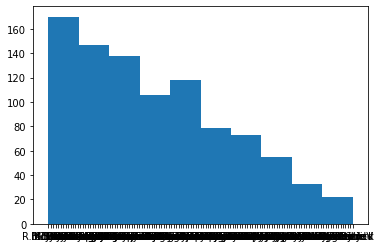

There are 2587 labeled samples, and 1.0% of kicker_player_name is not null.


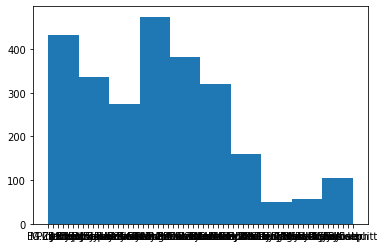

There are 938 labeled samples, and 0.36258214147661383% of return_team is not null.


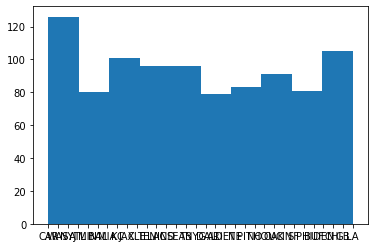

There are 2587 labeled samples, and 1.0% of return_yards is not null.


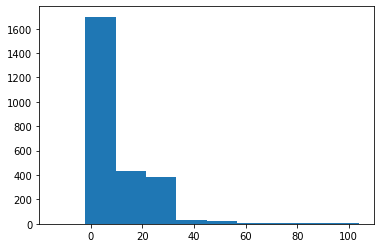

There are 645 labeled samples, and 0.24932354078082722% of kick_distance is not null.


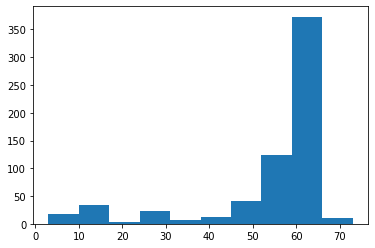

There are 2587 labeled samples, and 1.0% of touchback is not null.


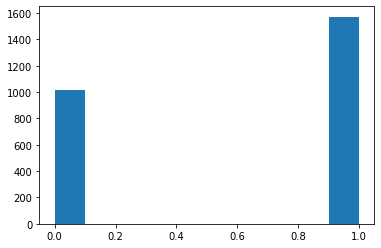

There are 2587 labeled samples, and 1.0% of kickoff_inside_twenty is not null.


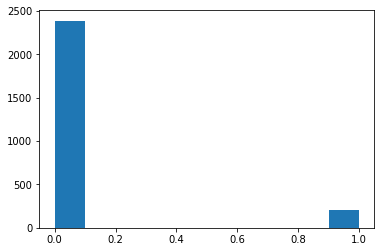

There are 2587 labeled samples, and 1.0% of kickoff_in_endzone is not null.


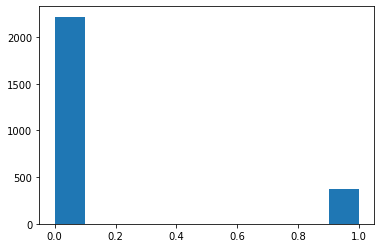

There are 2587 labeled samples, and 1.0% of kickoff_out_of_bounds is not null.


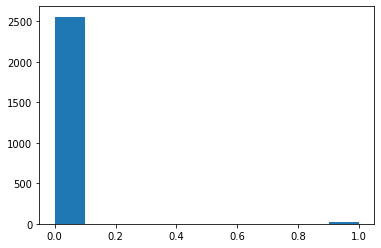

There are 2587 labeled samples, and 1.0% of kickoff_downed is not null.


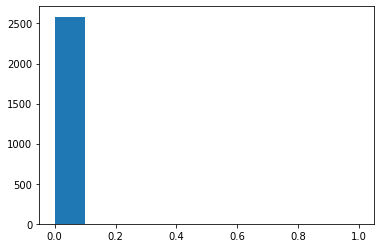

There are 2587 labeled samples, and 1.0% of kickoff_fair_catch is not null.


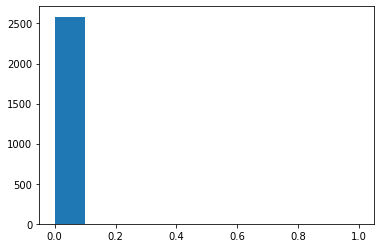

In [7]:
#checking categories
def summarizeCategory(categoryName):
    cat_len = len(kickoff_df[kickoff_df[categoryName].notna()][categoryName])
    have_data = cat_len/num_kickoffs
    print(f"There are {cat_len} labeled samples, and {have_data}% of {categoryName} is not null.")
    _ = plt.hist(kickoff_df[kickoff_df[categoryName].notna()][categoryName])
    plt.show()

categories = ["kickoff_returner_player_name", "kicker_player_name", "return_team", "return_yards",
                "kick_distance", "touchback", "kickoff_inside_twenty", 'kickoff_in_endzone', 
                'kickoff_out_of_bounds','kickoff_downed','kickoff_fair_catch']
    
for category in categories:
    summarizeCategory(category)

**Summary**<br>
As you can see, these categories aren't really consistent at all. They aren't all labeled at the same coverage and some categories make no sense (kick distance is 25 yards but it's a touchback--not out of bounds). This likely means that the webscraper used didn't work well on the kickoff stats. Luckily, we have the "desc" category that we can use to get stats from. Onto Regex!

### Harvesting Kickoff Stats with RE

In [8]:
#cutting down the df
kickoff_df = pbp_df[pbp_df["play_type"] == "kickoff"]
columns = ["play_id","game_id","home_team", "away_team", "posteam", "defteam", "desc",
          "kickoff_returner_player_name", "kicker_player_name"]
kickoff_df = kickoff_df[columns]

In [9]:
#checking out some descriptions
desc = list(kickoff_df.head(100)['desc'])
for _ in desc:
    print(_)

E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback.
E.Pineiro kicks 59 yards from CHI 35 to GB 6, out of bounds.
M.Crosby kicks 65 yards from GB 35 to end zone, Touchback.
M.Crosby kicks 65 yards from GB 35 to end zone, Touchback.
M.Crosby kicks 65 yards from GB 35 to end zone, Touchback.
G.Zuerlein kicks 65 yards from LA 35 to end zone, Touchback.
G.Zuerlein kicks 65 yards from LA 35 to CAR 0. R.McCloud to CAR 25 for 25 yards (T.Hill; M.Christian).
G.Zuerlein kicks 59 yards from LA 35 to CAR 6. R.McCloud to CAR 32 for 26 yards (T.Rapp).
G.Zuerlein kicks 65 yards from LA 35 to end zone, Touchback.
J.Slye kicks 65 yards from CAR 35 to end zone, Touchback.
G.Zuerlein kicks 62 yards from LA 35 to CAR 3, out of bounds.
J.Slye kicks 65 yards from CAR 35 to end zone, Touchback.
J.Slye kicks 65 yards from CAR 35 to end zone, Touchback.
J.Slye kicks 65 yards from CAR 35 to end zone, Touchback.
G.Zuerlein kicks 65 yards from LA 35 to end zone, Touchback.
J.Slye kicks onside 15 yards fr

In [10]:
def make_DF(texts):
    #FIRST SENTENCE
    kicker = [] #String
    isTouchback = [] #bool
    isOutOfBounds = [] #bool
    isOnside = [] #bool
    isFairCatch = [] #bool
    kick_yards = [] #int
    kick_start = [] #int
    
    tb = re.compile("Touchback")
    oob = re.compile("out of bounds")
    fc = re.compile("fair catch")
    kck_dist1 = re.compile("kicks( onside)? [0-9]{1,2} yards") #if you want to sort onside kicks... do it here.
    kck_dist2 = re.compile("[0-9]+") #kicks from 0-anything
    kck_spot1 = re.compile("from ([A-Z]{2,3} )?[0-9]{1,3} to (([A-Z]{2,3} )?-?[0-9]{1,3}|end zone)")
    kck_spot2 = re.compile("-?[0-9]{1,3}") #ints, strings?
    
    #SECOND SENTENCE
    returners = [] #String
    tacklers = [] #String
    returnYards = [] #int
    returnSpot = [] #int
    isReturned = [] #bool
    isAdvanced = [] #bool
    isTouchdown = [] #bool
    
    return_sent = re.compile("(\w)\.(\w)+(((\-| )\w+(\.)?)?) (((\(didn't try to advance\) )?(to ([A-Z]{1,3} )?[0-9]{1,3} )?)|((ran|pushed) ob at ([A-Z]{1,3} )?[0-9]{1,3}) )for ((-)?[0-9]{1,3} yard(s)?|(no gain))( \((((\w)\.(\w)+(((\-| )\w+(\.)?)?)(;|,) )*(\w)\.(\w)+(((\-| )\w+(\.)?)?))\))?")
    returner_sent = re.compile("(\w)\.(\w)+(((\-| )\w+(\.)?)?) (((\(didn't try to advance\) )?(to ([A-Z]{1,3} )?[0-9]{1,3} )?)|((ran|pushed) ob at ([A-Z]{1,3} )?[0-9]{1,3}) )for ((-)?[0-9]{1,3} yard(s)?|(no gain))")
    tackler_sent = re.compile("(((\(didn't try to advance\) )?(to ([A-Z]{1,3} )?[0-9]{1,3} )?)|((ran|pushed) ob at ([A-Z]{1,3} )?[0-9]{1,3}) )for ((-)?[0-9]{1,3} yard(s)?|(no gain))( \((((\w)\.(\w)+(((\-| )\w+(\.)?)?)(;|,) )*(\w)\.(\w)+(((\-| )\w+(\.)?)?))\))?")
    advanced = re.compile("\(didn't try to advance\)")
    touchdown = re.compile("TOUCHDOWN")
    name = re.compile("(\w\.\w+((\-| [A-Z])\w+)?\.?)")
    
    return_spot = re.compile("to (([A-Z]{1,3} )?[0-9]{1,3} )?|((ran|pushed) ob at ([A-Z]{1,3} )?[0-9]{1,3}) ")
    return_yards = re.compile("for ((-)?[0-9]{1,3} yard(s)?|(no gain))")
    spot = re.compile("-?[0-9]{1,3}") #should this have -
    yards = re.compile("-?[0-9]{1,3}")
    
    #(((\-| )\w+(\.)?)?)
    i=0
    for text in texts: #this runs in polynomial time, don't care about optimizing
        #FIRST SENTENCE
        #Kicker
        kicker.append(text.split(" kicks")[0])
        
        #Touchbacks
        tb_result = re.search(tb, text)
        if(tb_result != None):
            isTouchback.append(True)
        else:
            isTouchback.append(False)
        
        #Out of Bounds
        oob_result = re.search(oob, text)
        if(oob_result != None):
            isOutOfBounds.append(True)
        else:
            isOutOfBounds.append(False)
        
        #Onside Kick
        onside_result1 = re.search(kck_dist1, text)
        onside_result2 = re.search("onside", onside_result1.group())
        if(onside_result2 == None):
            isOnside.append(False)
        else:
            isOnside.append(True)
         
        #Fair Catch
        fc_result = re.search(fc, text)
        if(fc_result != None):
            isFairCatch.append(True)
        else:
            isFairCatch.append(False)
        
        #Kick Distance
        kck_dist_result = re.search(kck_dist1, text)
        if(kck_dist_result == None):
            print("ERROR")
        else:
            kck_dist_result = re.search(kck_dist2, kck_dist_result.group())
            kick_yards.append(int(kck_dist_result.group()))
            
        #Kick Start
        ks_result1 = re.search(kck_spot1, text)
        if(ks_result1 != None):
            ks_result1 = re.sub("end zone", "00", ks_result1.group())
            
            ks_result2 = re.findall(kck_spot2, ks_result1) #two item list of yardlines
        
            if(ks_result2[0] == None):
                print("ERROR")
            else:
                kick_start.append(int(ks_result2[0]))
            #REMOVING THIS SECTION FOR NOW, GOING TO PUT LAND AS START + KCK_DIST TO GET A MORE CLEAR VALUE.
            #THAT BEING SAID, THAT REMOVES THIS ALTERNATIVE CALCULATION THAT MIGHT THROW A FLAG.
            #if(ks_result2[1] == None):
            #    print("ERROR")
            #else:
            #    kick_land.append(ks_result2[1])
        #SECOND SENTENCE
        #Returner
        return_phrase = re.search(returner_sent, text)
        if(return_phrase == None):
            returners.append("no returner")
        else:
            returner = re.search(name, return_phrase.group())
            if(returner != None):
                returners.append(returner.group())
            else:
                returners.append("no returner")
                
        #Tackler(s)
        tackler_phrase = re.search(tackler_sent, text)
        if(tackler_phrase == None):
            tacklers.append("no tackler")
        else:
            tackler_list = re.findall(name, tackler_phrase.group())
            if(tackler_list != None):
                tacklers_ = []
                for tackler_items in tackler_list:
                    tacklers_.append(tackler_items[0])
                tacklers.append(tacklers_)
            else:
                tacklers.append("no tackler")
                
        #Return
        return_result = re.search(return_sent, text)
        if(return_result != None):
            isReturned.append(True)
        else:
            isReturned.append(False)
            
        
        #Advanced
        advanced_result = re.search(advanced, text)
        if(advanced_result != None):
            isAdvanced.append(False)
        else:
            isAdvanced.append(True)
        
        #Touchdown
        touchdown_result = re.search(touchdown, text)
        if(touchdown_result != None):
            isTouchdown.append(True)
        else:
            isTouchdown.append(False)
        
        #Return Spot
        
        
        #Return Yards
        ry_result = re.search(return_yards, text)
        if(ry_result):
            ry = re.sub("no gain", "00", ry_result.group())
            ry = re.search(yards, ry)
            if(ry):
                returnYards.append(int(ry.group()))
            else:
                print("ERROR", ry_result.group())
        else:
            returnYards.append(0)
            
    df = pd.DataFrame()
    #FIRST SENTENCE
    df["text"] = texts
    df["kicker"] = kicker
    df["isTouchback"] = isTouchback
    df["isOutOfBounds"] = isOutOfBounds
    df["isOnside"] = isOnside
    df["isFairCatch"] = isFairCatch
    df["kick_yards"] = kick_yards
    df["kick_start"] = kick_start
    df["kick_land"] = df["kick_start"] + df["kick_yards"]
    
    #SECOND SENTENCE
    df["returner"] = returners
    df["tacklers"] = tacklers
    df["return_yards"] = returnYards
    df["return_spot"] = df["kick_land"] - df["return_yards"]
    df["isReturned"] = isReturned
    df["isAdvanced"] = isAdvanced
    df["isTouchdown"] = isTouchdown
    return df

def printSample(num):
    for i in range(num):
        print(f"{i}:{df['text'][i]}")
        print(df.loc[i])

In [11]:
#testing makeDF method
texts = list(kickoff_df['desc'])
df = make_DF(texts)
df

,text,kicker,isTouchback,isOutOfBounds,isOnside,isFairCatch,kick_yards,kick_start,kick_land,returner,tacklers,return_yards,return_spot,isReturned,isAdvanced,isTouchdown
0,E.Pineiro kicks 65 yards from CHI 35 to end zo...,E.Pineiro,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
1,"E.Pineiro kicks 59 yards from CHI 35 to GB 6, ...",E.Pineiro,False,True,False,False,59,35,94,no returner,no tackler,0,94,False,True,False
2,M.Crosby kicks 65 yards from GB 35 to end zone...,M.Crosby,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
3,M.Crosby kicks 65 yards from GB 35 to end zone...,M.Crosby,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
4,M.Crosby kicks 65 yards from GB 35 to end zone...,M.Crosby,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,J.Myers kicks 65 yards from SEA 35 to end zone...,J.Myers,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
2583,M.Wishnowsky kicks 65 yards from SF 35 to end ...,M.Wishnowsky,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
2584,J.Myers kicks 65 yards from SEA 35 to end zone...,J.Myers,True,False,False,False,65,35,100,no returner,no tackler,0,100,False,True,False
2585,M.Wishnowsky kicks 43 yards from SF 35 to SEA ...,M.Wishnowsky,False,True,False,False,43,35,78,no returner,no tackler,0,78,False,True,False


**Summary**

In this summary, I'll walk through each of the statistics I added to the DF, how I generated them, and the sentence/line they were pulled from. The first two sentences provide the bulk of the data (kicking, returning, respectively) and there is some ancillary data from other sentences about muffs and penalties as well.

*First Sentence*<br>
In the first sentence, we learn the name of the *kicker*, the *kick_distance*, the *kick_start*, the *kick_land*, and whether the kick *isTouchback*, *isFairCatch*, *isOutOfBounds*, or *isOnside*.

Statistics:
1. *kicker* - the kicker is always the first word in the description. the existing DF did this correctly.
2. *isTouchback* - if the kick is a touchback. search for "Touchback".
3. *isFairCatch* - if the kick is a fair catch. search for "fair catch".
4. *isOutOfBounds* - if the kick is out of bounds. search for "out of bounds"
5. *isOnside* - if the kick is an onside kick. search for "onside" in "kicks onside ## yards".
6. *kick_yards* - the distance in the air of the kick. cut the number in "kick ## yards".
7. *kick_start* - where the kicker kicks from. cut "___ ##" in "from ___ ## to ___ ##".
8. *kick_land* - where the ball lands. can either be number or "end zone". cut "___ ##" or "end zone" in "from ___ ## to ___ ##". or... sum up kick_yards + kick_start for a clearer number
    - note: I use 0 to represent the kicking team's goal line, and 100 to represent the receiving team's goal line.

Challenges: 
1. First, there were 17 kicks out of 2878 that started from the 50 yard line. Neat! Forgot that in my regex tho.
2. Next, I spent an hour or so trying to figure out why I couldn't calculate kick_land... kick_start and kick_yards were String lists... Fun!

notes: check out of bounds...

*Second Sentence*<br>
In the second sentence, we learn the *isReturned*, *returner*, *return_distance*, *return_spot*, *tackler(s)*, *isTouchdown*, or *isAdvanced*.

Statistics:
1. *returner* - the player who returns the ball. search for the player pattern in a revised pattern with no tacklers.
2. *tacklers* - the player or players who tackle the returner. search for the player pattern in a revised pattern with no returner.
3. *return_distance* - the number of yards a returner takes the ball. search for _ yards, or "no gain".
4. *return_spot* - the yard mark where a return stops. subtract kick_land from return_yards.
5. *isReturned* - if the returner gets the ball, not counting fair catches. if the pattern returns, then there is a sentence of this form that describes the return.
    - note: this may not be entirely descriptive... not all of these entries are players looking to score or gain yards. non-returns overlap with touchbacks with the exception of weird plays like onside kicks, out of bounds, and fair catches.
6. *isAdvanced* - if the returner advances the ball. not relevant for touchbacks. search for "(didn't try to advance)".
7. *isTouchdown* - if there is a touchdown scored on the play--careful, negated touchdowns count too. search for "TOUCHDOWN"
    
Challenges: 
1. Did most of my development at https://regexr.com/5illa this time, made things a lot faster. My first RE for the sentence is almost entirely right... but it doesn't cover the case of player names like "R.Wilson Jr." or "T.Trent-Baylor". My formula was (\w)\.(\w)+.
2. Struggled with re.search() vs. re.findall()... re.findall() does not work how you would think it does. Check out my SO question here: https://stackoverflow.com/questions/65350068/re-search-and-re-findall.

*Other Sentences*
MUFFS, penalties, fumbles